In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer, required
from torch.utils.data import DataLoader, Subset
from collections import defaultdict


# 1. Simple CNN definition
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# 2. Data loaders
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])


full_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
full_val   = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)

def split_indices(dataset, classes):
    idxs = defaultdict(list)
    for i, (_, lbl) in enumerate(dataset):
        idxs[lbl].append(i)
    return [i for c in classes for i in idxs[c]]

first_classes, second_classes = list(range(5)), list(range(5,10))
train_idx1 = split_indices(full_train, first_classes)
train_idx2 = split_indices(full_train, second_classes)
val_idx1   = split_indices(full_val,   first_classes)
val_idx2   = split_indices(full_val,   second_classes)

bs = 10
train_loader1 = DataLoader(Subset(full_train, train_idx1),
                           batch_size=bs, shuffle=True, num_workers=2)
train_loader2 = DataLoader(Subset(full_train, train_idx2),
                           batch_size=bs, shuffle=True, num_workers=2)
val_loader1   = DataLoader(Subset(full_val,   val_idx1),
                           batch_size=bs, shuffle=False, num_workers=2)
val_loader2   = DataLoader(Subset(full_val,   val_idx2),
                           batch_size=bs, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# 3. Custom optimizer (SGD with optional LR decay in step)
import torch
from torch.optim import Optimizer


class AGASimple(Optimizer):
    def __init__(self, params, lr=1e-3, alpha_f=1e-2):
        defaults = dict(lr=lr, alpha_f=alpha_f)
        super().__init__(params, defaults)
        self.alpha_f = alpha_f
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['prev_grad'] = torch.zeros_like(p, requires_grad=False)

    @torch.no_grad()
    def step(self, closure=None):
        loss = closure() if closure is not None else None

    
        all_cur = []
        all_prev = []
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                all_cur.append(p.grad.view(-1))
                all_prev.append(self.state[p]['prev_grad'].view(-1))
        if not all_cur:
            return loss

        g_vec = torch.cat(all_cur)
        p_vec = torch.cat(all_prev)

        mat = torch.corrcoef(torch.stack([g_vec, p_vec])) 
        corr = mat[0,1]                                    
        s    = self.alpha_f * corr + 1.0

  
        if torch.all(p_vec == 0):
            s = 1.0
        
        print(s)

        
        for group in self.param_groups:
            base_lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # update
                p.sub_(base_lr * s * p.grad)

                # save grad for next iteration
                self.state[p]['prev_grad'] = p.grad.clone()

        return loss


class AGA_EMA(Optimizer):

    def __init__(self, params, lr=1e-3, alpha_f=1e-2, beta_ema=0.9):

        defaults = dict(lr=lr, alpha_f=alpha_f, beta_ema=beta_ema)
        super().__init__(params, defaults)

        # Initialize per-param state
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                # running EMA of gradient
                state['ema_grad']  = torch.zeros_like(p, requires_grad=False)
                state['ema_2_grad'] = torch.zeros_like(p, requires_grad=False)
                # per-param LR, same shape as p
                state['state_lr']  = torch.full_like(p, group['lr'])
                state['t'] = 0  # iteration count for EMA correction
                state['ema_sign'] = torch.zeros_like(p, requires_grad=False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step using an EMA of past gradients."""
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            alpha_f  = group['alpha_f']
            beta_ema = group['beta_ema']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]

                
                ema_old  = state['ema_grad']
                ema_new  = beta_ema * ema_old + (1 - beta_ema) * grad
                # update EMA of squared gradient
                ema_2_old = state['ema_2_grad']
                ema_2_new = beta_ema * ema_2_old + (1 - beta_ema) * grad * grad

                
                ema_sign_old = state['ema_sign']
                ema_sign_new = beta_ema * ema_sign_old + (1 - beta_ema) * torch.sign(grad * ema_old)
                lr = state['state_lr'] * (1 + alpha_f * ema_sign_new)

                eps = 1e-8  
                t = state['t'] + 1
                m_hat = ema_new     / (1 - beta_ema**t)
                v_hat = ema_2_new   / (1 - beta_ema**t)
                update = lr * m_hat / (v_hat.sqrt() + eps)
                p.sub_(update)

                state['ema_grad']  = ema_new.clone()
                state['ema_2_grad'] = ema_2_new.clone()
                state['t'] = t
                

        return loss
    
class Momentum(Optimizer):

    def __init__(self, params, lr=1e-3, alpha_f=1e-2, beta_ema=0.9):

        defaults = dict(lr=lr, alpha_f=alpha_f, beta_ema=beta_ema)
        super().__init__(params, defaults)


        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]

                state['ema_grad']  = torch.zeros_like(p, requires_grad=False)
                state['ema_2_grad'] = torch.zeros_like(p, requires_grad=False)
                state['state_lr']  = lr
                state['t'] = 0  # iteration count for EMA correction


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step using an EMA of past gradients."""
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            alpha_f  = group['alpha_f']
            beta_ema = group['beta_ema']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]

               
                ema_old  = state['ema_grad']
                ema_new  = beta_ema * ema_old + grad
               
                ema_2_old = state['ema_2_grad']
                ema_2_new = beta_ema * ema_2_old +  grad * grad
                lr = state['state_lr'] 
       
                eps = 1e-8  
                t = state['t'] + 1
                m_hat = ema_new     / (1 - beta_ema**t)
                v_hat = ema_2_new   / (1 - beta_ema**t)

                update = lr * m_hat / (v_hat.sqrt() + eps)
                p.sub_(update)

                state['ema_grad']  = ema_new.clone()
                state['ema_2_grad'] = ema_2_new.clone()
                state['t'] = t
                

        return loss
    





# 4. Training & validation loops
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_and_validate(opt_name, optimizer_fn):
    net = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_fn(net.parameters())

    history = []
    for epoch in range(10):
        # pick the right loaders
        if epoch < 5:
            tr_loader, vl_loader = train_loader1, val_loader1
        else:
            tr_loader, vl_loader = train_loader2, val_loader2

        # training
        net.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(net(xb), yb)
            loss.backward()
            optimizer.step()

        # validation (on same subset)
        net.eval()
        correct = total = 0
        with torch.no_grad():
            for xb, yb in vl_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = net(xb).argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        acc = correct/total
        history.append(acc)
        print(f'{opt_name} Epoch {epoch+1}: Val Acc = {acc:.4f}')

    return history

In [12]:


# 6. Run experiments
histories = {}

In [ ]:
# 5. Define optimizer factories
optimizers = {
    'SGD+Momentum': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    'SGD+Nesterov': lambda params: optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True),
    'Adam': lambda params: optim.AdamW(params, lr=0.001),
    'Nadam': lambda params: optim.NAdam(params, lr=0.001, weight_decay=0.01, decoupled_weight_decay=True),
    'aGAS': lambda params: AGASimple(params, lr=0.1, alpha_f=0.9),
    'aGAS_EMA': lambda params: AGA_EMA(params, lr=0.001, alpha_f=0.1),
    'SGD': lambda params: optim.SGD(params, lr=0.1),
    'Momentum': lambda params: Momentum(params, lr=0.001, beta_ema=0.9),
}

for name, fn in optimizers.items():
    print(f'\n==> Training with {name}')
    histories[name] = train_and_validate(name, fn)


==> Training with SGD+Momentum


SGD+Momentum Epoch 1: Val Acc = 0.6774
SGD+Momentum Epoch 2: Val Acc = 0.7320
SGD+Momentum Epoch 3: Val Acc = 0.7396
SGD+Momentum Epoch 4: Val Acc = 0.7588
SGD+Momentum Epoch 5: Val Acc = 0.7402
SGD+Momentum Epoch 6: Val Acc = 0.8172
SGD+Momentum Epoch 7: Val Acc = 0.8488
SGD+Momentum Epoch 8: Val Acc = 0.8564
SGD+Momentum Epoch 9: Val Acc = 0.8556
SGD+Momentum Epoch 10: Val Acc = 0.8538

==> Training with SGD+Nesterov
SGD+Nesterov Epoch 1: Val Acc = 0.7074
SGD+Nesterov Epoch 2: Val Acc = 0.7374
SGD+Nesterov Epoch 3: Val Acc = 0.7176
SGD+Nesterov Epoch 4: Val Acc = 0.7756
SGD+Nesterov Epoch 5: Val Acc = 0.7774
SGD+Nesterov Epoch 6: Val Acc = 0.8336
SGD+Nesterov Epoch 7: Val Acc = 0.8582
SGD+Nesterov Epoch 8: Val Acc = 0.8508
SGD+Nesterov Epoch 9: Val Acc = 0.8390
SGD+Nesterov Epoch 10: Val Acc = 0.8584

==> Training with Adam
Adam Epoch 1: Val Acc = 0.7074
Adam Epoch 2: Val Acc = 0.7710
Adam Epoch 3: Val Acc = 0.7928
Adam Epoch 4: Val Acc = 0.8066
Adam Epoch 5: Val Acc = 0.8048
Adam Ep

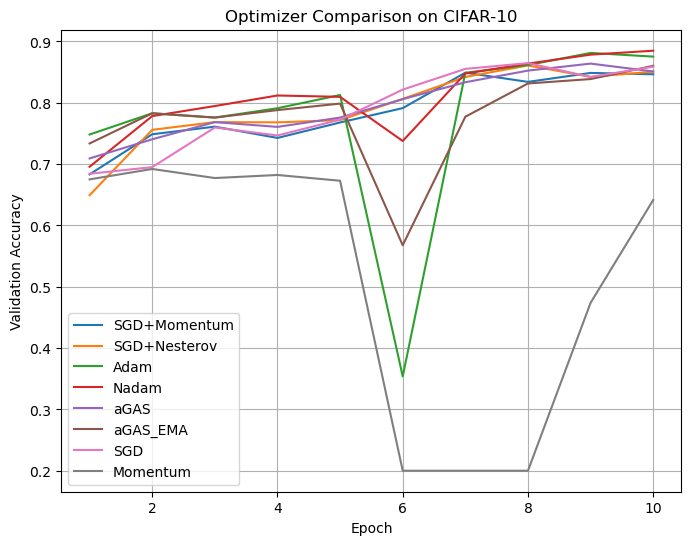

In [ ]:
# 7. Plot learning curves
plt.figure(figsize=(8,6))
for name, hist in histories.items():
    plt.plot(range(1, len(hist)+1), hist, label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Optimizer Comparison on CIFAR-10')
plt.legend()
plt.grid(True)
plt.show()
